# Around Black-Scholes and Local Volatility

We offer you the following practical task on Black-Scholes and local volatility models.

Total score is **100**, which will be converted to $25\%$ of the course grade. You have 3 weeks and a half for this work. **Deadline is 13th of November, 23:59 MSK**.

The file must be sent to **stoch-vol-24-fall@yandex.ru** with topic "stoch-vol Lab1".  Please rename your file as **"SurnameName_Lab1.ipynb"** before sending.

If you have any questions feel free to ask in the **group chat**.

**Full name:** Anastasia Makhova

**Faculty:**  of Mechanics and Mathematics, MSU

In [1]:

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st
from collections.abc import Callable
from tqdm.auto import trange
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

## Episode 0: Lab Scoring System 💅 (0 points)

In [2]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import pandas as pd

Maximum lab score is 100.
If you hand in the lab before the soft deadline, your final score is what you solved.
After the soft deadline maximum lab score lineary decays towards zero, and your final score is your score **multiplied (not capped!)** by the factor less then 1.
The value of the factor depends on how much you missed the soft deadline.

In [3]:
ZONE = ZoneInfo("Europe/Moscow")
ASSIGNMENT_DT = datetime(2024, 10, 16, 23, 30, 0, tzinfo=ZONE)
NO_PENALTY_PERIOD = timedelta(days=21)
HARD_DEADLINE = datetime(2024, 11, 13, 23, 59, 59, tzinfo=ZONE)
MAX_LAB_SCORE = 100

In [4]:
def get_score_multiplier(lab_hand_dt: datetime = datetime.now().astimezone()) -> float:
    """Calculate overeall lab score multiplier.

    The function calculates the lab score weighting factor, based on time,
    when the solved lab was handed in. The factor equals 1 during the
    `NO_PENALTY_PERIOD` starting at the `ASSIGNMENT_DT, then lineary decays
    towards 0 by the `HARD_DEADLINE` date.

    Args:
        lab_hand_dt: datetime when the lab is handed in. Now by default. Must be
        timezone-aware.

    Returns:
        A factor between 0 and 1, by which the final score will be multiplied.
    """
    assert lab_hand_dt.tzinfo is not None,\
        "The argument must be timezone-aware. Use `datetime.astimezone()` "\
        "to use your local timezone."

    if lab_hand_dt < ASSIGNMENT_DT + NO_PENALTY_PERIOD:
        return 1.

    decay_period = HARD_DEADLINE - ASSIGNMENT_DT - NO_PENALTY_PERIOD
    elapsed_with_penalty = lab_hand_dt - ASSIGNMENT_DT - NO_PENALTY_PERIOD
    factor = 1. - elapsed_with_penalty.total_seconds() / decay_period.total_seconds()
    return max(0., factor)

In [5]:
HAND_IN_DT = datetime.now().astimezone()
LAB_SCORE = 100
print(f"Final score is {int(LAB_SCORE * get_score_multiplier(HAND_IN_DT))}")

Final score is 100


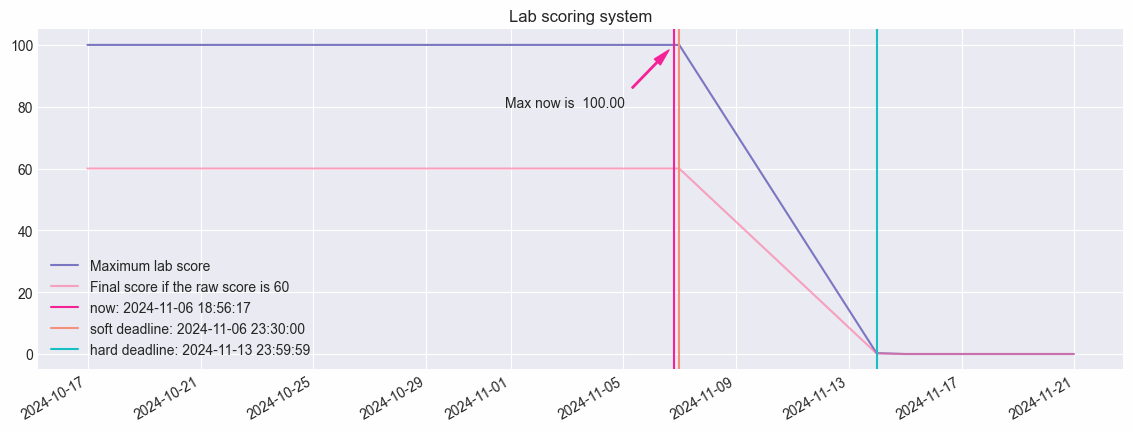

In [6]:
EXAMPLE_SCORE = 60

index = pd.date_range(ASSIGNMENT_DT, HARD_DEADLINE + timedelta(days=7))
mult = index.map(get_score_multiplier)
score = pd.DataFrame(
    index=index,
    data={
        "Maximum lab score": mult * MAX_LAB_SCORE,
        f"Final score if the raw score is {EXAMPLE_SCORE}": mult * EXAMPLE_SCORE,
    }
)

sd = ASSIGNMENT_DT + NO_PENALTY_PERIOD
hd = HARD_DEADLINE
now = datetime.now().astimezone()
score_now = get_score_multiplier(now) * MAX_LAB_SCORE

_, ax = plt.subplots(figsize=(14, 5))
score.plot(ax=ax)
ax.set_title("Lab scoring system")
ax.axvline(now, c="C2", label=f"now: {now:%F %T}")
ax.axvline(sd, c="C4", label=f"soft deadline: {sd:%F %T}")
ax.axvline(hd, c="C3", label=f"hard deadline: {hd:%F %T}")
ax.annotate(
    text=f"Max now is {score_now: .2f}",
    xy=(now, score_now),
    xytext=(now - timedelta(days=6), score_now - 20),
    arrowprops=dict(
        facecolor="C2", edgecolor="C2", shrink=0.1, width=1, headwidth=6
    ),
)
ax.legend()
plt.show()

---

## Episode 1: Around Black-Scholes model 🧠 (50 points)

**1**. 💅 <span style="color:blue">(10 points)</span>  

A call spread is an option strategy in which a call option is bought, and another less expensive call option is sold. That is, the payoff of the call spread at expiration $T$ can be given as

$$\text{Call-spread}(K_1, K_2) = (S_T - K_1)_{+} - (S_T - K_2)_{+}, \qquad K_1 < K_2.$$

Plot **call-spread** option prices as functions of the underlying asset price for different **exercise times** and different **volatilities**. Use parameters

$$K_1 = 1, \quad K_2 = 1.2, \quad r = 0, \quad S \in [0.5, 1.5],$$

and $T \in \{0,\ \frac{1}{4},\ \frac{1}{2},\ \frac{3}{4},\ 1\}$ (time is measured in years) and $\sigma \in \{0.1, \ 0.2, \ 0.3\}$.

*Note: the answer should contain three plots (for each volatility $\sigma$), each of which shows option prices for different excercise times $T$.*

In [7]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from ipywidgets import interact
from ipywidgets import widgets
from tqdm.auto import tqdm


In [8]:
FloatArray = npt.NDArray[np.float64]
Floats = Union[float, FloatArray]

In [9]:
@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]]

    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)

class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

@dataclass
class BSParams:
    volatility: Floats

In [10]:
def dt(option: StockOption, ms: MarketState):
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)

def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

In [11]:
def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))

    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price

    return np.where(option.is_call, call_price, put_price)

In [12]:
strike1 = 1
strike2 = 1.2
times = np.linspace(0, 1, 5)
sigma = np.array([0.1, 0.2, 0.3])
calls1 = CallStockOption(strike_price=strike1,
                      expiration_time=times[:, None])
calls2 = CallStockOption(strike_price=strike2,
                      expiration_time=times[:, None])

S = np.linspace(0.5, 1.5, 101)

ms = MarketState(stock_price=S, interest_rate=0)


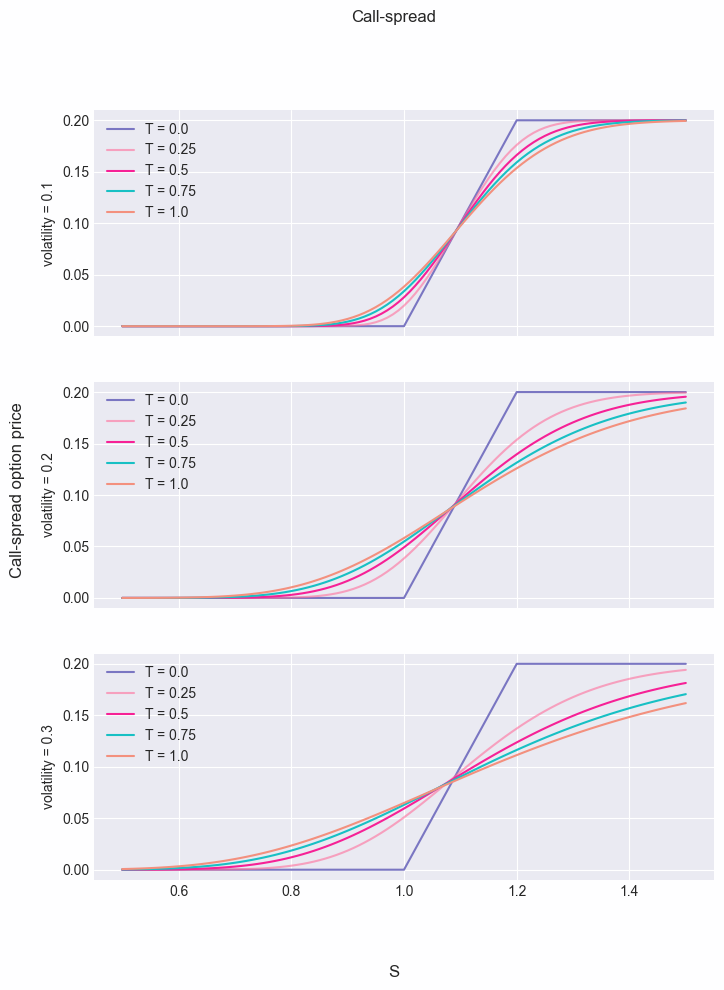

In [13]:
fig, ax = plt.subplots(3, sharex=True, figsize=(8, 10))
fig.suptitle('Call-spread')
for i in range(3):
  params = BSParams(volatility=sigma[i])
  call_spread_price = price(calls1, ms, params) - price(calls2, ms, params)
  for t in range(5):
    ax[i].plot(S,call_spread_price[t,:], label = 'T = '+ str(times[t]))
  ax[i].legend()
  ax[i].set_ylabel('volatility = '+ str(sigma[i]))

fig.supylabel('Сall-spread option price')
fig.supxlabel('S');


---

**2**. 💅 <span style="color:blue">(10 points)</span>  What kind of dependence on the parameters of call-spread option price do you observe? How does the price of it depend on the spot price $S$, volatility $\sigma$ and time to expiration $T$? Why? Provide the intuition.

* $S\uparrow \Rightarrow V \uparrow$ (follows directly from the payoff function)
* $\sigma \uparrow  \Rightarrow$ 
    - bend is smaller: first derivative is smaller, i.e. delta is smaller
    - curves diverge more from the values at $T = 0$: OTM options are more expensive and ITM are cheaper
* $T \uparrow \Rightarrow$ OTM options are more expensive and ITM are cheaper

---

**4**. 💅 <span style="color:blue">(10 points)</span> Replicate considered call-spread option using the portfolio rebalanced $n$ times (i.e. every $dt = T/n$ units of time). Using simulations, estimate the distribution of the replication error.


    1) Generate m random trajectories of price process trajectories on the segment [0,t] with a step dt = T/n.

    2) For each trajectory at each moment of time, find a replicating portfolio. Assume that the initial value of the portfolio is equal to the option price.

    3) For each trajectory, calculate the difference between the value of the replicating portfolio at time T and the payout to be made on the option.

    4) Display the distribution of the obtained differences in the form of a histogram.

*Note: use, for instance, $m = 2^{10} - 1$ and $n$ = 123*.

*Note: Remember that you are replicating your call-spread in Black-Scholes model. So, you may use any formulas available in this model (Black-Scholes option's price formula, greeks, etc.) .*

In [14]:
def make_bsm_market_simulator(
    ms: MarketState,
    params: BSParams,
    time_stop: float,
    n_steps: int,
):

    def simulate(n_paths: int, seed: int = 0xB0BA_C_3AB0DA):
        dt = (time_stop - ms.time) / n_steps
        random = np.random.default_rng(seed)
        norm = random.normal(size=(n_paths, n_steps))
        d_log_s = (
            (ms.interest_rate - params.volatility ** 2 / 2) * dt
            + params.volatility * norm * np.sqrt(dt)
        )
        d_log_s = np.insert(d_log_s, 0, np.zeros(n_paths), axis=1)
        return ms.stock_price * np.exp(np.cumsum(d_log_s, axis=-1))

    return simulate

In [15]:
def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = stats.norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)

In [16]:
def calc_hedging_pnl(
    option1: StockOption,
    option2: StockOption,
    ms: MarketState,
    params: BSParams,
    n_steps: int,
    n_paths: int,
    seed: int = 0xB0BA_C_3AB0DA,
):
    sim_fn = make_bsm_market_simulator(ms, params, option1.expiration_time, n_steps)
    paths = sim_fn(n_paths, seed)                                            # paths.shape == (n_paths, n_steps + 1)
    times = np.linspace(ms.time, option1.expiration_time, n_steps + 1)[None]  # times.shape == (1,       n_steps + 1)
    bank_acc = 1.0 * np.exp(ms.interest_rate * (times - times[:, 0]))
    df = 1.0 / bank_acc

    inter_ms = MarketState(
        stock_price=paths,
        interest_rate=ms.interest_rate,
        time=times,
    )

    opt1_p = price(option1, inter_ms, params)
    opt2_p = price(option2, inter_ms, params)
    opt_p = opt1_p - opt2_p 

    stock_pos1 = delta(option1, inter_ms, params)
    stock_pos2 = delta(option2, inter_ms, params)
    stock_pos = stock_pos1 - stock_pos2 

    bank_acc_pos = df * (opt_p - stock_pos * paths)
    hedging_pnl = (
        stock_pos[:, :-1] * np.diff(paths, axis=-1)
        + bank_acc_pos[:, :-1] * np.diff(bank_acc, axis=-1)
    )
    payoff = -(option1.payoff(paths[:, [-1]])-option2.payoff(paths[:, [-1]]))
    return np.append(hedging_pnl, payoff, axis=-1)

In [17]:
m = 2**10 -1
n = 123

T = 1.0
r = 0.0
S = 1
K1 = 1
K2 = 1.2
vol = 0.167
seedseed = 42

In [18]:
option1 = CallStockOption(strike_price=K1, expiration_time=T)
option2 = CallStockOption(strike_price=K2, expiration_time=T)
ms = MarketState(stock_price=S, interest_rate=r)
params = BSParams(volatility=vol)

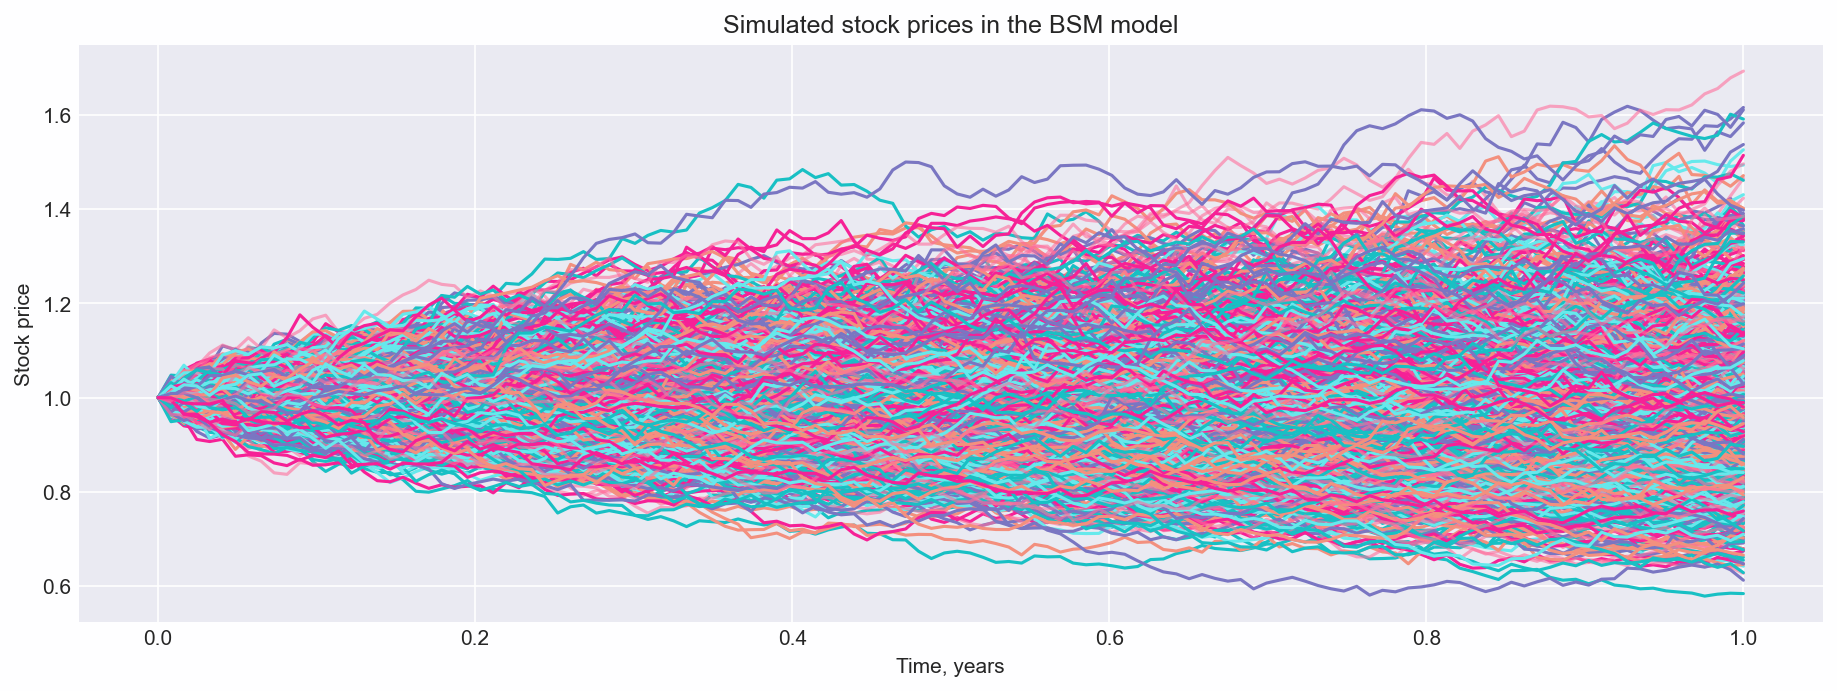

In [19]:
sim_fn = make_bsm_market_simulator(ms, params, T, n)
paths = sim_fn(m, seedseed)

t = np.linspace(0, T, n + 1)
_, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax.plot(t, paths.T)
ax.set_xlabel("Time, years")
ax.set_ylabel("Stock price")
ax.set_title("Simulated stock prices in the BSM model")
plt.show()

In [20]:

H = calc_hedging_pnl(
    option1,
    option2,
    ms,
    params,
    n_paths=m,
    n_steps=n,
    seed=seedseed,
)

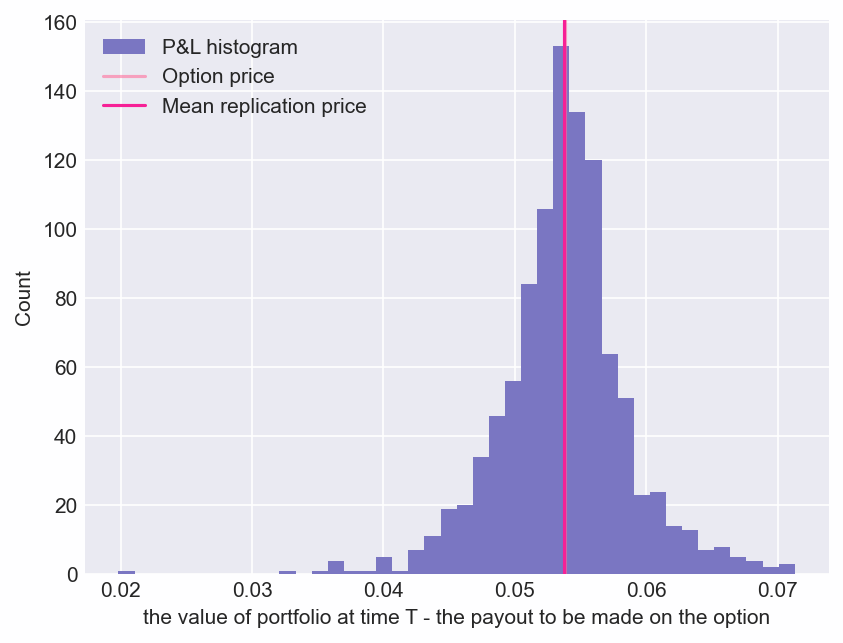

In [21]:
p = price(option1, ms, params) - price(option2, ms, params)
_, ax = plt.subplots(dpi=150)
ax.hist(-H.sum(-1), bins=42,  label="P&L histogram")
ax.axvline(p, c="C1", label="Option price")
ax.axvline(-H.sum(-1).mean(), c="C2", label="Mean replication price")
ax.set_xlabel("the value of portfolio at time T - the payout to be made on the option")
ax.set_ylabel("Count")
ax.legend()
plt.show()

---

**5**. 🧠 <span style="color:blue">(20 points)</span> Let $C_{call} (S_t, r, \sigma, t) := C(t, S_t)$ be a call option price where $C(t, S)$ satisfies BS equation. Suppose that we sell a call option at $t=0$ at implied volatility $\hat \sigma$, i.e. we get the premium $C_{call}(S_0, r, \hat \sigma, 0)$. Hence the hedging strategy is such that the number of the risky asset held at time $t$ is $$H_t = \dfrac{\partial C}{\partial S}.$$ Moreover, suppose that the true dynamics of asset price is **not** geometric Brownian motion $dS_t = r S_t dt + \sigma S_t dW_t$, but is given by more general Ito process

$$dS_t = \alpha_t S_t dt + \beta_t S_t dW_t. $$  

5.1 <span style="color:blue">(2 points out of 20)</span> Using strategy $H_t$, write SDE for the value $X_t$ of hedging portfolio, assuming that we hold $\dfrac{\partial C}{\partial S}$ units of risky asset and $X_t - \dfrac{\partial C}{\partial S} S_t$ money in riskless one.

$$dX_t = H_t dS_t + G_t dB_t = \frac{\partial{C}}{\partial{S}}(\alpha_tS_tdt + \beta_tS_tdW_t) + \frac{(X_t - \frac{\partial{C}}{\partial{S}}S_t )}{B_t}(rB_tdt) =\\ (\frac{\partial{C}}{\partial{S}}\alpha_tS_t + X_tr -\frac{\partial{C}}{\partial{S}}S_tr )dt + \frac{\partial{C}}{\partial{S}}\beta_tS_tdW_t $$


5.2 <span style="color:blue">(2 points out of 20)</span> Assume that $Y_t = C(t, S_t)$. Applying Ito formula to $Y_t$, write SDE for $Y_t$.  

$$
dY_t = C'_t dt + C'_S dS_t + \frac{1}{2}C''_{SS} (dS)^2 = (C'_t + C'_S\alpha_tS_t + \frac{1}{2} C''_{SS}\beta_t^2S_t^2)dt + (C'_S\beta_t S_t)dW_t
$$


5.3 <span style="color:blue">(6 points out of 20)</span> Using answers from 5.1 and 5.2 and BS equation, show that hedging error $Z_t = X_t - Y_t$ satisfies

$$\dfrac{d}{dt} Z_t = r Z_t + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right).$$

$$\dfrac{d}{dt} Z_t = \dfrac{d}{dt} X_t - \dfrac{d}{dt}Y_t =  (C'_S\alpha_tS_t + X_tr -C'_SS_tr) - (C'_t + C'_S\alpha_tS_t + 0.5 C''_{SS}\beta_t^2S_t^2)=\\ - C'_t -C'_SS_tr - 0.5 C''_{SS}\beta_t^2S_t^2 + X_tr$$

From BS equation: $ C'_t + C'_SS_tr + 0.5\hat \sigma^2 S_t^2 C''_{SS} = rC $

Given $C = Y_t$ and $Z_t = X_t -Y_t $. By substituting $ - C'_t - C'_SS_tr  =  0.5\hat \sigma^2 S_t^2 C''_{SS} - rY_t$ in equation for $\dfrac{d}{dt} Z_t$, we get
$$ \dfrac{d}{dt} Z_t  = Z_tr + 0.5 S_t^2 (\hat \sigma^2 - \beta_t^2)C''_{SS} $$

5.4 <span style="color:blue">(6 points out of 20)</span> Solve the equation for $Z_t$ above and show that

$$Z_T = \int_{0}^{T} e^{r(T-t)} \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta_t^2 \right) dt. $$

By the previous problem: $$ \dfrac{d}{dt} Z_t - Z_tr = 0.5 S_t^2 (\hat \sigma^2 - \beta_t^2)C''_{SS} $$

Multiply both sides by integration factor $e^{-rt}$:
$$ \dfrac{dZ_t}{dt} e^{-rt} - re^{-rt} Z_t = 0.5 S_t^2 (\hat \sigma^2 - \beta_t^2)C''_{SS} $$
$$ \dfrac{d}{dt} (e^{-rt} Z_t) = 0.5 S_t^2 (\hat \sigma^2 - \beta_t^2)C''_{SS}$$

Intergrate both sides from 0 to T:
$$ e^{-rT} Z_T - e^{-r0} Z_0 = \int_0^T 0.5 e^{-rt}S_t^2 (\hat \sigma^2 - \beta_t^2)C''_{SS} dt $$

As $Z_0 = 0$ (at $t = 0$ error is zero):
$$  Z_T = \int_0^T 0.5 e^{r(T-t)}S_t^2 (\hat \sigma^2 - \beta_t^2)C''_{SS}dt$$

5.5 <span style="color:blue">(4 points out of 20)</span> Looking at the results above, is it possible to make a **profit with probability one** even though the true price model is substantially different from the assumed model (GBM)? What condition is sufficient for getting this profit?

To make a profit with probability one, $0.5 e^{r(T-t)}S_t^2 (\hat \sigma^2 - \beta_t^2)C''_{SS}$ should be greater than zero.

As $ 0.5 e^{r(T-t)}S_t^2 > 0$ holds for all $t, T, S_t$, we need $(\hat \sigma^2 - \beta_t^2)C''_{SS} > 0$

- long option: $\Gamma =  C''_{SS} >0$. If $ \hat \sigma^2 >\beta_t^2$, we get profit with probability one.
- short option: $\Gamma =  C''_{SS}<0 $. If $ \hat \sigma^2<\beta_t^2$, we get profit with probability one.

Since we are selling a call option, we have a short call. By taking $ \hat \sigma^2<\beta_t^2$ (for example $\hat \sigma$ close to zero), it is possible to make profit with probability one


---

---

## Episode 2: Local volatility from Monte Carlo perspective 🧠 (50 points)

Here you need to implement the Monte-Carlo pricing in Local Volatility model. For that purpose, you can use the standrad *Euler* discretization scheme:

$$S_{t_{i + 1}} = S_{t_i} + \sigma_{Dup}(t_i, S_{t_i}) \Delta W_{t_i}.$$

However, direct usage of such scheme may lead to negative values of the prices $S_t$. For that reason, you may apply the Euler scheme to $\log(S_{t_i})$ and then finally put $S_{t_i} = e^{X_{t_i}}$. From Ito's formula,

$$X_{t_{i + 1}} = X_{t_i} - \frac{1}{2} \sigma^2_{Dup}(t_i, e^{X_{t_i}}) \Delta t_i+ \sigma_{Dup}(t_i, e^{X_{t_i}}) \Delta W_{t_i}.$$

Notice that for correct implementation, you need a full Dupire volatility surface function. For that reason, you should construct a properly inter-and-extrapolated function $(t, s) \to \sigma_{IV}(t, s)$, obtained from real-market data. Then you may use the well-known formula converting the observed implied volatilites $\sigma_{IV}(t, s)$ to Dupire local volatilies $\sigma_{Dup}(t, s)$:

$$ \sigma_{Dup}(T, K) = \sqrt{\dfrac{\frac{\partial w}{\partial T}}{1 - \frac{y}{w} \frac{\partial w}{\partial y} + \frac{1}{4} ( -\frac{1}{4} - \frac{1}{w} + \frac{y^2}{w^2}) (\frac{\partial w}{\partial y})^2 + \frac{1}{2} \frac{\partial^2 w}{\partial y^2}}},$$


where
$w(K, T) = \sigma^{2}_{IV}(K, T) \cdot T$ is implied variance and $y = \log(K / F_T)$ is forward log-moneyness.

Use, for instace, spline interpolation in $(w, y)$ coordinates. You may use alo flat extrapolation, i.e. for a pair of arguments $(t, K)$, firstly make the following tranformation

$$ t' = \begin{cases} t_{\min}, & t<t_{\min} \\
   t,        & t \in[t_{\min}, t_{\max}],\\
   t_{\max}, & t > t_{\max},
        \end{cases} \qquad

   s' = \begin{cases} s_{\min}, & s<s_{\min}, \\
                     s, & s \in[s_{\min}, s_{\max}], \\
                     s_{\\max}, & s > s_{\max},
        \end{cases} \qquad
$$

where $t_{\min}, t_{\max}, s_{\min}, s_{\max}$ - minimum and maximum values of time to expiration and strikes variables from the market data and
$$\sigma^{new}_{Dup}(t,s) = \sigma_{Dup}(t', s').$$
   

In [22]:
s = 1.0    # spot price S_0
r = 0.0    # zero interest rate

**1**. 🧠 <span style="color:blue">(10 points)</span>

Extract the data from `data.txt`: strikes, times to expiration and call option prices. Compute the corresponding implied volatilties $\sigma_{IV}(T_i, K_i)$, inter-and-extrapolate them to obtain the whole surface. Plot the calculated implied volatility curves for each time to marutiry $T_i$ and the whole implied volatility surface.

In [23]:
import py_vollib.black.implied_volatility as iv

In [24]:
expiration = np.loadtxt("data.txt", usecols=0, skiprows=1, delimiter=",")
strike = np.loadtxt("data.txt", usecols=1, skiprows=1, delimiter=",")
call_price = np.loadtxt("data.txt", usecols=2, skiprows=1, delimiter=",")

In [25]:
ms = MarketState(stock_price=s, interest_rate=r)

In [26]:
ivs = []

for i in range(len(call_price)):
    impl_vol = iv.implied_volatility(
        call_price[i],
        ms.stock_price,
        strike[i],
        ms.interest_rate,
        expiration[i]-ms.time,
        "c"
    )
    ivs.append(impl_vol)
implied_vols = np.array(ivs)

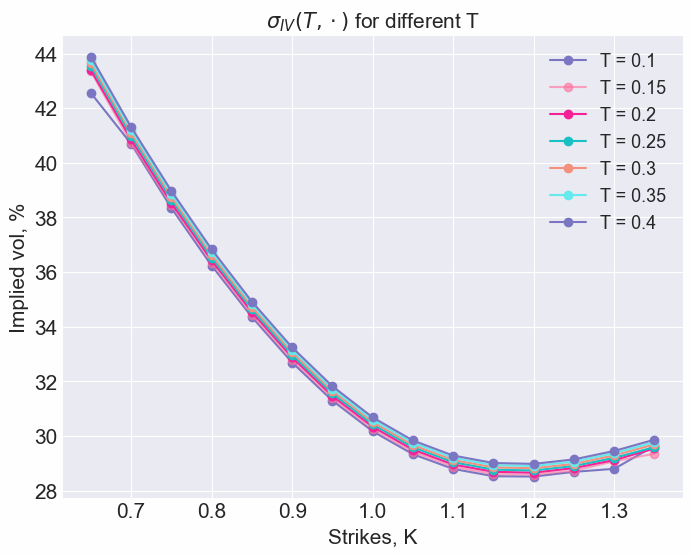

In [27]:
plt.figure(figsize=(8, 6))

for tenor in np.unique(expiration):
    strikes_ = strike[np.where(expiration == tenor)[0]]
    implied_vols_for_tenor_ = implied_vols[np.where(expiration == tenor)[0]]
    label="T = {}".format(round(float(tenor), 2))
    plt.plot(strikes_, 100 * np.array(implied_vols_for_tenor_), label=label, marker = "o")
    
plt.title("$\\sigma_{IV}(T, \\cdot)$ for different T", fontsize=15)
plt.ylabel("Implied vol, %", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(prop={'size': 13})
plt.grid(True)
plt.show()

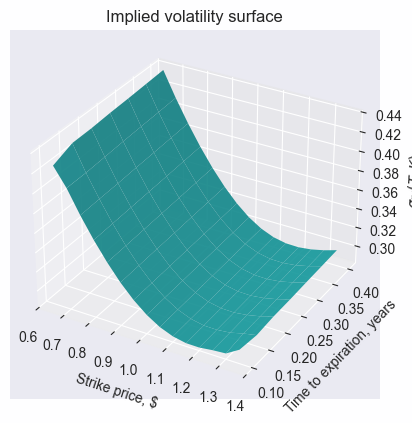

In [28]:
ax = plt.figure().add_subplot(projection='3d')

strike_grid, expiration_grid = np.meshgrid(np.unique(strike), np.unique(expiration))
implied_vols_grid = implied_vols.reshape(strike_grid.shape)

ax.plot_surface(strike_grid, expiration_grid, implied_vols_grid,alpha=0.9, color = 'C3')
#ax.scatter(strike, expiration, implied_vols )
ax.set_title("Implied volatility surface")
ax.set_xlabel('Strike price, $')
ax.set_ylabel('Time to expiration, years')
ax.set_zlabel("$\\sigma_{IV}(T, K)$");

Interpolation:
1. extending the axis

In [29]:
def array_inter_extr(array, k, flag):
    '''
    Create an array with additional points for inerpolation with step 1/k
    and add 1 point at the ends for extrapolation 
    ''' 
    array_plus = np.linspace(np.min(array), np.max(array), len(np.unique(array))*k-(k-1)) #add points for interpolation
    if(k == 1):
        array_plus = np.insert(array_plus,0, -array_plus[1]+2*array_plus[0])#add points for extrapolation
        array_plus = np.append(array_plus, -array_plus[-2]+2*array_plus[-1])
    
    return array_plus

In [30]:
k_s = 2
strike_plus = array_inter_extr(strike, k_s, 1)
strike_plus

array([0.65 , 0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 ,
       0.875, 0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075,
       1.1  , 1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  ,
       1.325, 1.35 ])

In [31]:
k_e = 2
expiration_plus = array_inter_extr(expiration, k_e, 0)
expiration_plus

array([0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 , 0.275, 0.3  ,
       0.325, 0.35 , 0.375, 0.4  ])

2. a.  Cubic and linear interpolation

In [32]:
from scipy.interpolate import CubicSpline

In [33]:
tol = 1e-10

In [34]:
#for each T, let`s make an interpolation of IV(K_i) with a cubic spline and for each K_i along T-axis -- linearly 
iv_plus = np.empty((len(expiration_plus),len(strike_plus)))
for tenor in np.unique(expiration):
    implied_vols_for_tenor_ = implied_vols[np.where(expiration == tenor)[0]]
    cs = CubicSpline(np.unique(strike), implied_vols_for_tenor_, bc_type='natural')
    iv_plus[np.where(np.abs(expiration_plus-tenor)<tol)[0]] =  cs(strike_plus, nu=0)

for i in range(len(expiration_plus)):
    if((i% k_e)!=0):
       iv_plus[i]  = iv_plus[i-(i%k_e) + k_e]*(i%k_e) /(k_e) + iv_plus[i - (i%k_e)] *(k_e -i%k_e) /(k_e)


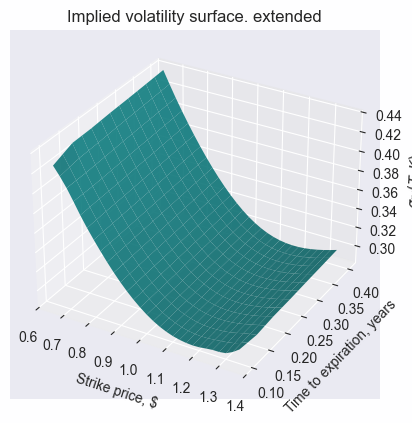

In [35]:
ax = plt.figure().add_subplot(projection='3d')

expiration_p_grid, strike_p_grid, = np.meshgrid(expiration_plus, strike_plus)
iv_p_grid = iv_plus.T#.reshape(expiration_p_grid.shape)

ax.plot_surface(  strike_p_grid,expiration_p_grid, iv_p_grid ,alpha=0.9, color = 'C3')
ax.set_title("Implied volatility surface. extended")
ax.set_xlabel('Strike price, $')
ax.set_ylabel('Time to expiration, years')
ax.set_zlabel("$\\sigma_{IV}(T, K)$");

~~well... something definitely went  wrong~~(UPD: I`ve found a mistake, anyway, let it be two different interpolations) I'll do another interpolation.

2. b. SmoothBivariateSpline 

In [36]:
from scipy.interpolate import SmoothBivariateSpline 

In [37]:
plus = SmoothBivariateSpline(strike, expiration, implied_vols)

In [38]:
x, y = np.meshgrid(strike_plus, expiration_plus)
iv_plus = plus(x, y,grid=False)

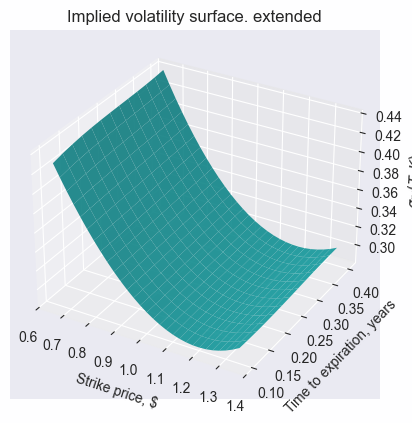

In [39]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_surface( x, y, iv_plus ,alpha=0.9, color = 'C3')
ax.set_title("Implied volatility surface. extended")
ax.set_xlabel('Strike price, $')
ax.set_ylabel('Time to expiration, years')
ax.set_zlabel("$\\sigma_{IV}(T, K)$");

**2**. 🧠 <span style="color:blue">(20 points)</span>

Write a function which evaluates a Dupire local volatility at given point, i.e. a function $(t, s) \to \sigma_{Dup}(t, s)$. Please note that it should return an "adequate" value for any input point $(t, s)$ from the considered ranges of strieks and times to expiration. Plot the obtained local volatility surface for a given grid of strikes and times to expiration.

In [40]:
t_min, t_max, s_min, s_max  = expiration.min(), expiration.max(), strike.min(), strike.max()

In [41]:

#def local_volatility(implied_vols, expiration, strike, T, S, t_min, t_max, s_min, s_max):
def local_volatility( T, S):
    Y = np.log(strike/(s * np.exp(r * expiration)))
    W = np.power(implied_vols, 2)*expiration

    w_interpolate = SmoothBivariateSpline(expiration, Y, W)

    T_ = np.clip(T, t_min, t_max)
    S_ = np.clip(S, s_min, s_max)
    T_, S_ = np.meshgrid(T_, S_ )
    
    Y_= np.log(S_/(s * np.exp(r * T_)))

    w_ = w_interpolate(T_,Y_, grid=False) 
    w_t = w_interpolate.partial_derivative(1,0)(T_,Y_,grid=False)
    w_y = w_interpolate.partial_derivative(0,1)(T_,Y_,grid=False)
    w_yy = w_interpolate.partial_derivative(0,2)(T_,Y_,grid=False)

    numerator = w_t
    denominator = (1 - (Y_/w_)*w_y + 0.25*(-0.25 - 1/w_ + np.power(Y_/w_, 2)) * np.power(w_y,2) + 0.5*w_yy)

    return np.sqrt(numerator / denominator)


In [42]:
T, S = expiration_plus, strike_plus
lv_dup = local_volatility(T, S)

T_ = np.clip(T, t_min, t_max)
S_ = np.clip(S, s_min, s_max)
T_, S_ = np.meshgrid(T_, S_ )



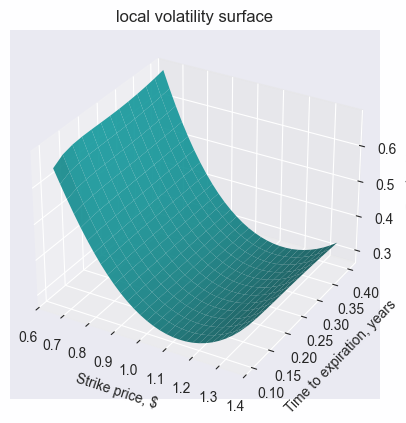

In [43]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(S_, T_,  lv_dup ,alpha=0.9, color = 'C3')
ax.set_title("local volatility surface")
ax.set_xlabel('Strike price, $')
ax.set_ylabel('Time to expiration, years')
ax.set_zlabel("$\\sigma_{Dup}(T, K)$");

**3**. 🧠 <span style="color:blue">(20 points)</span>

Implement a Monte-Carlo simulation calculator and price an option with time to expiration $T = 0.25$ for the range of strikes $K = \{ 0.6, 0.7, 0.8, \dots, 1.4\}$. Your calculator should return a range of prices $\{ V(T, K_i)\}$ and implied volatilites $\sigma_{IV}(T, K_i)$ (for each strike $K_i$), with an absolute error not greater than $1\%$ in implied vols for every (almost every) strike $K_i$. Plot on one graph the prices obtained using Monte Carlo and the prices from the file. Also, plot on other graph the implied vols obtained using Monte Carlo and the implied vols obtained in question (1).

In [44]:
T = 0.25
K = np.linspace(0.6, 1.4, 9)
call_price_ = call_price[np.where(expiration == T)[0]]

Generation of $S_t$ by *Euler* discretization scheme:

In [45]:
def Euler_MC(n_paths, n_steps, T, s, seed):
    dt = T / n_steps
    random = np.random.default_rng(seed)
    norm = random.normal(size=(n_paths, n_steps))
    paths = np.empty((n_paths, n_steps))
    paths[:,0] = np.log(s)
    for i in range(1, n_steps):
        loc_vol = local_volatility(np.full((n_paths),(i-1)*dt), np.exp(paths[:,i-1]))
        paths[:,i] = paths[:, i-1] - 0.5 *loc_vol[:,0]**2 *dt  + loc_vol[:,0] * norm[:, i-1] * np.sqrt(dt)
    return np.exp(paths)

In [60]:
m = 2000
n = 125
MC_sim = Euler_MC(m, n, T, s, seedseed)

In [61]:
S = np.reshape(MC_sim[:, -1], (-1, 1))
Strike= np.reshape(K, (1, -1))
MC_price = np.exp(-r*T) * np.mean(np.maximum(np.zeros(np.shape(S-Strike)), S - Strike), axis = 0)

In [62]:
ivs = []

for i in range(len(K)):
    try:
        impl_vol = iv.implied_volatility(
            MC_price[i],
            np.exp(-r * T) * s,
            K[i],
            r,
            T,
            "c"
        )
        ivs.append(impl_vol)
    except Exception as e: # iv throws exceptions. can't understand why. leave it like that to see images
        ivs.append(np.nan) 

MC_IV = np.array(ivs)

In [63]:
MC_IV

array([0.47489887, 0.41317452, 0.36793153, 0.3299606 , 0.30336521,
       0.29367138, 0.29714606, 0.30355634, 0.30251191])

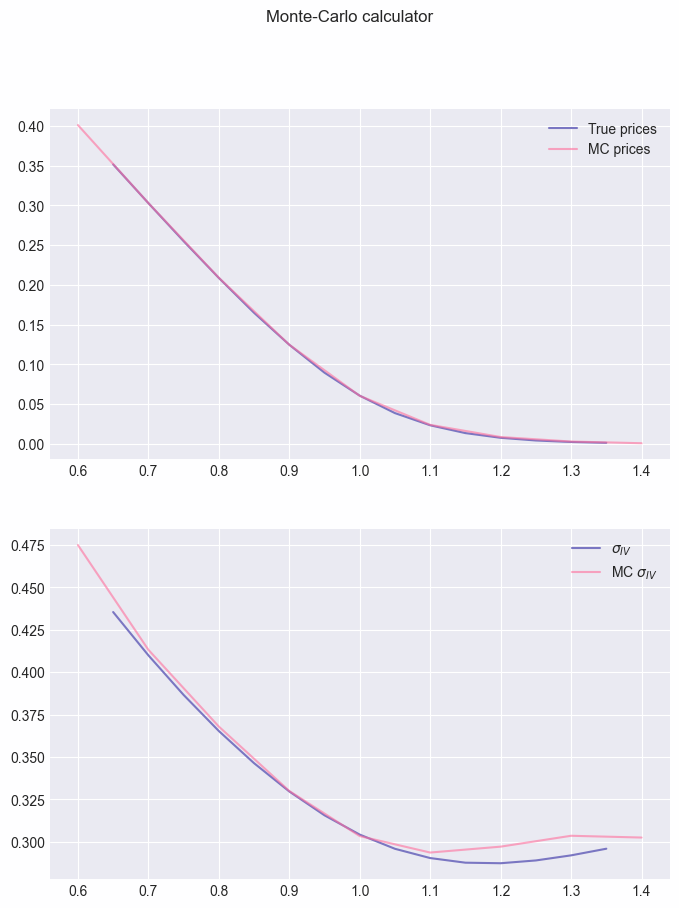

In [64]:
fig, ax = plt.subplots(2, figsize=(8, 10))
fig.suptitle('Monte-Carlo calculator')

ax[0].plot(strike[expiration== T], call_price_, label = 'True prices')
ax[0].plot(K, MC_price, label = 'MC prices')
ax[0].legend()


ax[1].plot(strike[expiration== T], implied_vols[expiration == T], label = '$\\sigma_{IV}$')
ax[1].plot(K,MC_IV, label = 'MC $\\sigma_{IV}$')
ax[1].legend();

~~The implied volatility doesn't seem to be happy about the bugs that are hidden in the code...~~ (UPD: take $n$ and $m$ as big as possible, otherwise volatility smile of (MC $\sigma_{IV}$) looks like a ...very sad one)